In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

import networkx as nx

# ATB vs LTBI 

Load *significant* logFC changes for genes between ATB & LTBI samples collected from various studies

In [3]:
#use this path for personal computer
microarray_diff_exp_data = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Microarray Differential Gene Expression/ATB_v_LTBI/"

#use this path for Gates MRI computer
#microarray_diff_exp_data = "/Users/RogerVargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Microarray Differential Gene Expression/ATB_v_LTBI/"

diff_gene_exp_df = pd.read_csv(microarray_diff_exp_data + 'signif_logFC_across_studies.csv').set_index('Unnamed: 0')
diff_gene_exp_df.rename_axis('gene' , inplace = True)

In [4]:
diff_gene_exp_df.head()

,GSE19439,GSE19442,GSE19444,GSE28623,GSE37250,GSE39939,GSE39940,GSE41055,GSE54992,GSE62525,GSE69581,GSE73408
gene,,,,,,,,,,,,
CFAP157,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CECR2,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPB49,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ODF2L,-0.678457,-0.80683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PTCSC2,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Construct simplified matrix of logFC *direction* from DataFrame with significant logFC changes across all analyses by converting values:
   1. $+1$ if logFC > 0
   1. $0$ if logFC = 0
   1. $-1$ if logFC < 0

In [5]:
#store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

#replace values in logFC matrix
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

#convert to lower memory int8 datatype
direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

In [6]:
direc_diff_gene_exp_matrix

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0, -1,  0, ...,  1, -1,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int8)

In [7]:
np.shape(direc_diff_gene_exp_matrix)

(29004, 12)

### Compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
### Compute $M \cdot M^T \text{ to get } i \cdot j \text{ , } \forall \text{ pairs of rows } i, j \text{ in matrix } M$ 

In [8]:
#multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
network_edge_weight_matrix = direc_diff_gene_exp_matrix.dot(direc_diff_gene_exp_matrix.T)

#the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))

In [9]:
network_edge_weight_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [10]:
np.shape(network_edge_weight_matrix)

(29004, 29004)

In [11]:
network_edge_weight_matrix_labels.head()

0    CFAP157
1      CECR2
2      EPB49
3      ODF2L
4     PTCSC2
dtype: object

In [12]:
np.shape(network_edge_weight_matrix_labels)

(29004,)

### Investigate sparsity of matrix

In [13]:
float(np.sum(network_edge_weight_matrix == 0)) / float(np.shape(network_edge_weight_matrix)[0]*np.shape(network_edge_weight_matrix)[1])

0.9493005221047127

The matrix has ~95% sparsity, when constructing the network, we will **only** connect nodes (genes) with weights that are **non-zero** values. 

In [14]:
print( 'Number of Edges ~ ' + str(int(float(np.sum(network_edge_weight_matrix != 0))/2.0)) )

Number of Edges ~ 21325012


### Investigate the distribution of the Edge Weights

In [23]:
#Return the upper triangular part of the matrix with elements in lower part zeroed out
upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

#Return all non-zero elements
edge_weight_array = upper_tri_network_edge_weight_matrix[np.nonzero(upper_tri_network_edge_weight_matrix)]

In [28]:
edge_weight_array

array([2, 1, 1, ..., 1, 1, 3], dtype=int8)

In [27]:
len(edge_weight_array)

21330186

In [29]:
np.min(edge_weight_array)

-11

In [30]:
np.max(edge_weight_array)

11

In [31]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

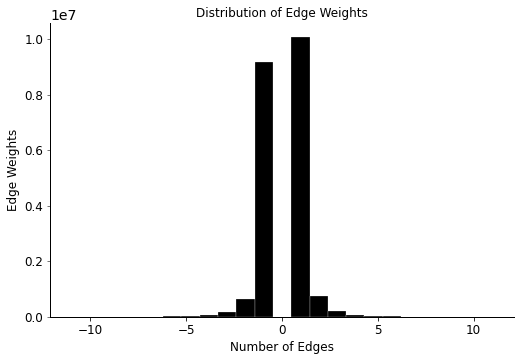

In [37]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(edge_weight_array , bins = 23 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=0.25)

plt.title('Distribution of Edge Weights', fontsize = 12, color = 'k')
plt.xlabel('Number of Edges', fontsize = 12, color = 'k')
plt.ylabel('Edge Weights' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
#ax.set_yscale('log')

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

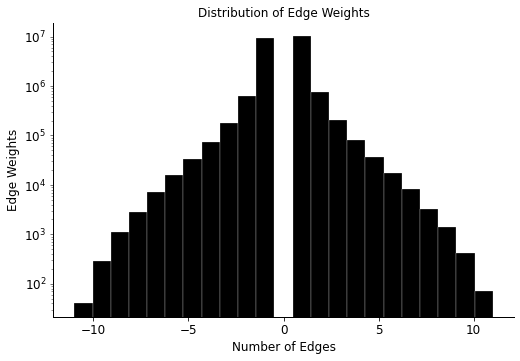

In [36]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(edge_weight_array , bins = 23 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=0.25)

plt.title('Distribution of Edge Weights', fontsize = 12, color = 'k')
plt.xlabel('Number of Edges', fontsize = 12, color = 'k')
plt.ylabel('Edge Weights' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.set_yscale('log')

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### Construct NetworkX graph from edge weight matrix

Test Graph construction on a **subset** of the edge weight matrix

In [15]:
network_edge_weight_matrix_test = network_edge_weight_matrix[0:1000 , 0:1000]

In [16]:
network_edge_weight_matrix_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 2, 1],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int8)

In [17]:
np.shape(network_edge_weight_matrix_test)

(1000, 1000)

In [18]:
network_edge_weight_matrix_labels_test = network_edge_weight_matrix_labels[0:1000]

In [19]:
network_edge_weight_matrix_labels_test.head()

0    CFAP157
1      CECR2
2      EPB49
3      ODF2L
4     PTCSC2
dtype: object

#### Retrieve the indices for the upper-triangular part of the matrix (including the diagonal)

In [24]:
#store the indices for the upper triangular part of the matrix
triu_indices = np.triu_indices(np.shape(network_edge_weight_matrix_test)[0], k = 0)

#simplify variable names for numpy (adjancency) matrix (with edge weights) & node labels (rows/columns of matrix)
matrix = network_edge_weight_matrix_test
gene_labels = network_edge_weight_matrix_labels_test

#### Create list of edges for NetworkX graph by iterating through (upper-triangular) edge weight matrix & storing edges with weights $\not = 0$

In [25]:
G_edge_list = [ (gene_labels[node_i], gene_labels[node_j], matrix[node_i, node_j]) for node_i, node_j in zip(triu_indices[0], triu_indices[1]) if matrix[node_i, node_j] != 0 ]

In [29]:
G_edge_list[0:5]

[('ODF2L', 'ODF2L', 2),
 ('ODF2L', 'TSPAN13', 1),
 ('ODF2L', 'ZBTB5', 1),
 ('ODF2L', 'ZAP70', 2),
 ('ODF2L', 'SLC6A16', 1)]

In [26]:
len(G_edge_list) #number of edges (gene-gene pairs with weight != 0)

23717

#### Construct NetworkX graph from list of Edges

In [27]:
G = nx.Graph()
G.add_weighted_edges_from(G_edge_list)

In [28]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 350
Number of edges: 23717
Average degree: 135.5257


## Extra Stuff Below

In [24]:
#Convert edge weight numpy array to DataFrame
ATB_v_LTBI_network_edge_weight_df = pd.DataFrame(ATB_v_LTBI_network_edge_weight_matrix , index = ATB_v_LTBI_network_edge_weight_matrix_labels , columns = ATB_v_LTBI_network_edge_weight_matrix_labels)

### Agglomerative Clustering of genes by edge weights

In [ ]:
#cluster
gene_edge_weight_link = fastcluster.linkage_vector(ATB_v_LTBI_network_edge_weight_matrix, method='single', metric='euclidean')

#get the new order of the genes
gene_order = hier.leaves_list(gene_edge_weight_link)

#re-order the pairwise SNP distance matrix according to the new clustering order
reordered_data_subset = ATB_v_LTBI_network_edge_weight_matrix[gene_order, :]
reordered_data_subset = reordered_data_subset[:, gene_order]

Get the gene list according to the re-ordered edge weights array

In [ ]:
ATB_v_LTBI_network_edge_weight_matrix_labels = ATB_v_LTBI_network_edge_weight_matrix_labels[gene_order]

In [ ]:
ATB_v_LTBI_network_edge_weight_matrix_labels.head()

### Heatmap of gene edge weights on clustered matrix

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=300)
gs = gridspec.GridSpec(3, 3,
                       width_ratios=[1.5,10,0.25],
                       height_ratios=[1.5,10,0.25],
                       wspace=0.03,
                       hspace=0.03)

# # x ywidth height
ax1 = fig.add_subplot(gs[0,1], frameon=False)
Z1 = dendrogram(Z=gene_edge_weight_link, color_threshold=None, leaf_rotation=45, link_color_func=lambda x: link_cols[x] , no_labels = True , orientation='top', ax=ax1) # adding/removing the axes
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1,0], frameon=False)
Z2 = dendrogram(Z=gene_edge_weight_link, color_threshold=None, leaf_rotation=45, link_color_func=lambda x: link_cols[x] , no_labels = True , orientation='left', ax=ax2) # adding/removing the axes
ax2.set_xticks([])
ax2.set_yticks([])

axmatrix = fig.add_subplot(gs[1,1])
# norm=mpl.colors.Normalize(vmin=0, vmax=40)
im = axmatrix.matshow(reordered_data_subset.T, aspect='auto', origin='lower', cmap=plt.cm.Greys_r, interpolation='none')

ax_cbar = fig.add_subplot(gs[1,2])
cbar = plt.colorbar(im , cax = ax_cbar)
cbar.set_label('Gene Edge Weight' , rotation = -90, va='bottom')

axmatrix.set_xticks([])
axmatrix.set_yticks([])

fig.tight_layout()
#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/FOR_CHANG_pairwise_SNP_distance/figures/isolates_genetic_aggl_clustered.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()